In [1]:
# сначала профета устанавливал так:
# %conda install -c conda-forge fbprophet
# Профет fit вызывал краш кернела ноутбука

# Сделал так:
# %conda remove pystan fbprophet
# %conda install --channel conda-forge pystan fbprophet
# Заработало

In [2]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
PATH_TO_DATA = r'../data/'

calendar = pd.read_csv(PATH_TO_DATA + 'calendar.csv')
df_eval = pd.read_csv(PATH_TO_DATA + 'sales_train_evaluation.csv')
df_val = pd.read_csv(PATH_TO_DATA + 'sales_train_validation.csv')
df_sell = pd.read_csv(PATH_TO_DATA + 'sell_prices.csv')

In [4]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.

    Requirements: 
    import numpy as np        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

In [5]:
# Пока буду работать только с одним штатом
df_ca_state = df_val.copy()
df_ca_state = df_ca_state[df_ca_state.state_id == 'CA']

In [6]:
reduce_mem_usage(df_ca_state);

Memory usage of dataframe is 178.65MB
Memory usage after optimization is: 35.74MB
Decreased by 80.0%


In [7]:
df_ca_state.head(3)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  

[3 rows x 1919 columns]

In [8]:
df_val.state_id.value_counts()

CA    12196
TX     9147
WI     9147
Name: state_id, dtype: int64

In [9]:
df = pd.melt(df_ca_state, 
            id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
            var_name='d', 
            value_name='sales').dropna()

In [10]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales  
0       CA  d_1      0  
1       CA  d_1      0  
2       CA  d_1      0  
3       CA  d_1      0  
4       CA  d_1      0

In [11]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [12]:
df = df.merge(calendar, on='d', how='left')

In [13]:
df.describe().T

count          mean         std      min      25%      50%  \
sales     23330948.0      1.229078    4.107153      0.0      0.0      0.0   
wm_yr_wk  23330948.0  11339.191323  150.374184  11101.0  11217.0  11333.0   
wday      23330948.0      3.997386    2.000652      1.0      2.0      4.0   
month     23330948.0      6.357554    3.458773      1.0      3.0      6.0   
year      23330948.0   2013.209096    1.532086   2011.0   2012.0   2013.0   
snap_CA   23330948.0      0.329326    0.469968      0.0      0.0      0.0   
snap_TX   23330948.0      0.329326    0.469968      0.0      0.0      0.0   
snap_WI   23330948.0      0.329326    0.469968      0.0      0.0      0.0   

              75%      max  
sales         1.0    763.0  
wm_yr_wk  11448.0  11613.0  
wday          6.0      7.0  
month         9.0     12.0  
year       2015.0   2016.0  
snap_CA       1.0      1.0  
snap_TX       1.0      1.0  
snap_WI       1.0      1.0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23330948 entries, 0 to 23330947
Data columns (total 21 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            category
 1   item_id       category
 2   dept_id       category
 3   cat_id        category
 4   store_id      category
 5   state_id      category
 6   d             object  
 7   sales         int16   
 8   date          object  
 9   wm_yr_wk      int64   
 10  weekday       object  
 11  wday          int64   
 12  month         int64   
 13  year          int64   
 14  event_name_1  object  
 15  event_type_1  object  
 16  event_name_2  object  
 17  event_type_2  object  
 18  snap_CA       int64   
 19  snap_TX       int64   
 20  snap_WI       int64   
dtypes: category(6), int16(1), int64(7), object(7)
memory usage: 2.8+ GB


In [15]:
df.describe(exclude='int64').T

count unique                          top      freq  \
id              23330948  12196  FOODS_1_001_CA_1_validation      1913   
item_id         23330948   3049                  FOODS_1_001      7652   
dept_id         23330948      7                      FOODS_3   6297596   
cat_id          23330948      3                        FOODS  10995924   
store_id        23330948      4                         CA_1   5832737   
state_id        23330948      1                           CA  23330948   
d               23330948   1913                        d_569     12196   
sales         23330948.0    NaN                          NaN       NaN   
date            23330948   1913                   2014-09-17     12196   
weekday         23330948      7                     Saturday   3341704   
event_name_1     1878184     30                    Purim End     73176   
event_type_1     1878184      4                    Religious    634192   
event_name_2       48784      4                 Father's day     12196   
event_type_2       48784      2                     Cultural     36588   

                  mean       std  min  25%  50%  75%    max  
id                 NaN       NaN  NaN  NaN  NaN  NaN    NaN  
item_id            NaN       NaN  NaN  NaN  NaN  NaN    NaN  
dept_id            NaN       NaN  NaN  NaN  NaN  NaN    NaN  
cat_id             NaN       NaN  NaN  NaN  NaN  NaN    NaN  
store_id           NaN       NaN  NaN  NaN  NaN  NaN    NaN  
state_id           NaN       NaN  NaN  NaN  NaN  NaN    NaN  
d                  NaN       NaN  NaN  NaN  NaN  NaN    NaN  
sales         1.229078  4.107153  0.0  0.0  0.0  1.0  763.0  
date               NaN       NaN  NaN  NaN  NaN  NaN    NaN  
weekday            NaN       NaN  NaN  NaN  NaN  NaN    NaN  
event_name_1       NaN       NaN  NaN  NaN  NaN  NaN    NaN  
event_type_1       NaN       NaN  NaN  NaN  NaN  NaN    NaN  
event_name_2       NaN       NaN  NaN  NaN  NaN  NaN    NaN  
event_type_2       NaN       NaN  NaN  NaN  NaN  NaN    NaN

In [16]:
sales_ca_state = df.groupby('d').agg({'sales':'sum'}).reset_index()

In [17]:
sales_ca_state = sales_ca_state.merge(calendar, on='d', how='left')
sales_ca_state = sales_ca_state.drop(columns='d')


In [18]:
sales_ca_state['date'] = pd.to_datetime(sales_ca_state['date'])

In [19]:
sales_ca_state.date.duplicated().sum()

0

In [20]:
plt.figure(figsize=(25,5))
sns.lineplot(data = sales_ca_state, x = 'date', y='sales')
plt.show()

In [21]:
sales_ca_state[sales_ca_state.sales < 100]

sales       date  wm_yr_wk    weekday  wday  month  year event_name_1  \
71        5 2013-12-25     11348  Wednesday     5     12  2013    Christmas   
476       6 2014-12-25     11447   Thursday     6     12  2014    Christmas   
881       6 2015-12-25     11547     Friday     7     12  2015    Christmas   
1172      8 2011-12-25     11148     Sunday     2     12  2011    Christmas   
1577      6 2012-12-25     11248    Tuesday     4     12  2012    Christmas   

     event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
71       National          NaN          NaN        0        0        0  
476      National          NaN          NaN        0        0        0  
881      National          NaN          NaN        0        0        0  
1172     National          NaN          NaN        0        0        0  
1577     National          NaN          NaN        0        0        0

# Facebook Prophet

In [141]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import (plot_yearly, 
                            add_changepoints_to_plot, 
                            plot_plotly, 
                            plot_components_plotly,
                            plot_cross_validation_metric)

In [23]:
df_for_prophet = sales_ca_state.copy()
df_for_prophet = df_for_prophet[['sales', 'date']]
df_for_prophet.rename(columns={'sales':'y', 'date':'ds'}, inplace=True)

In [24]:
df_for_prophet.head(2)

y         ds
0  14195 2011-01-29
1  11822 2011-02-07

In [25]:
model_porophet = Prophet()
model_porophet.fit(df_for_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
future = model_porophet.make_future_dataframe(periods=365)    # period for forecast - 36 monthes
forecast = model_porophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
2273 2017-04-20  17985.212368  15739.402414  20184.814435
2274 2017-04-21  19691.565478  17334.318627  21882.869455
2275 2017-04-22  23184.649277  20973.393338  25321.296761
2276 2017-04-23  23445.635442  21248.878504  25677.618053
2277 2017-04-24  19539.529552  17354.372357  21628.751770

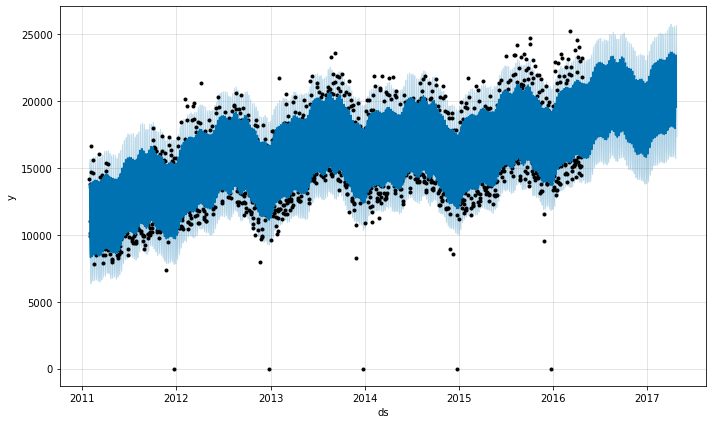

In [42]:
fig1 = model_porophet.plot(forecast, uncertainty=True)

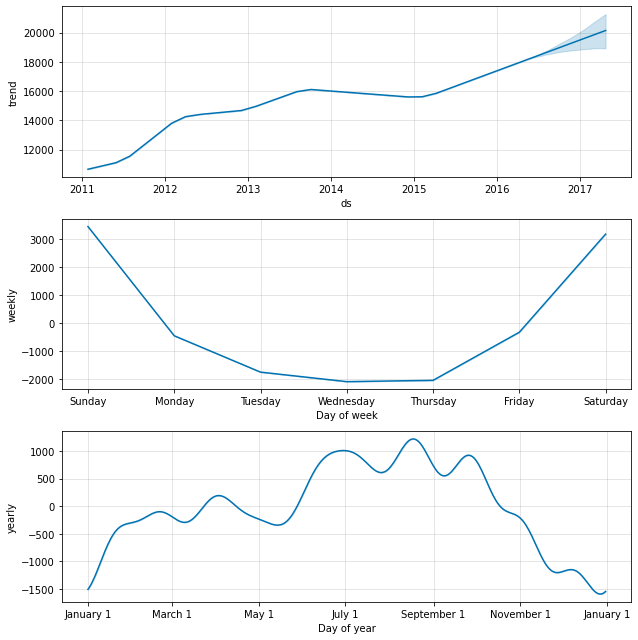

In [28]:
fig2 = model_porophet.plot_components(forecast)

In [29]:
plot_plotly(model_porophet, forecast)

In [30]:
plot_components_plotly(model_porophet, forecast)

In [44]:
m2 = Prophet(holidays=holidays)
m2.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m2.add_seasonality('monthly', period=30.5, fourier_order=5)
m2.add_country_holidays(country_name='US')

In [45]:
m2.fit(df_for_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
future2 = m2.make_future_dataframe(periods=365)
forecast2 = m2.predict(future2)

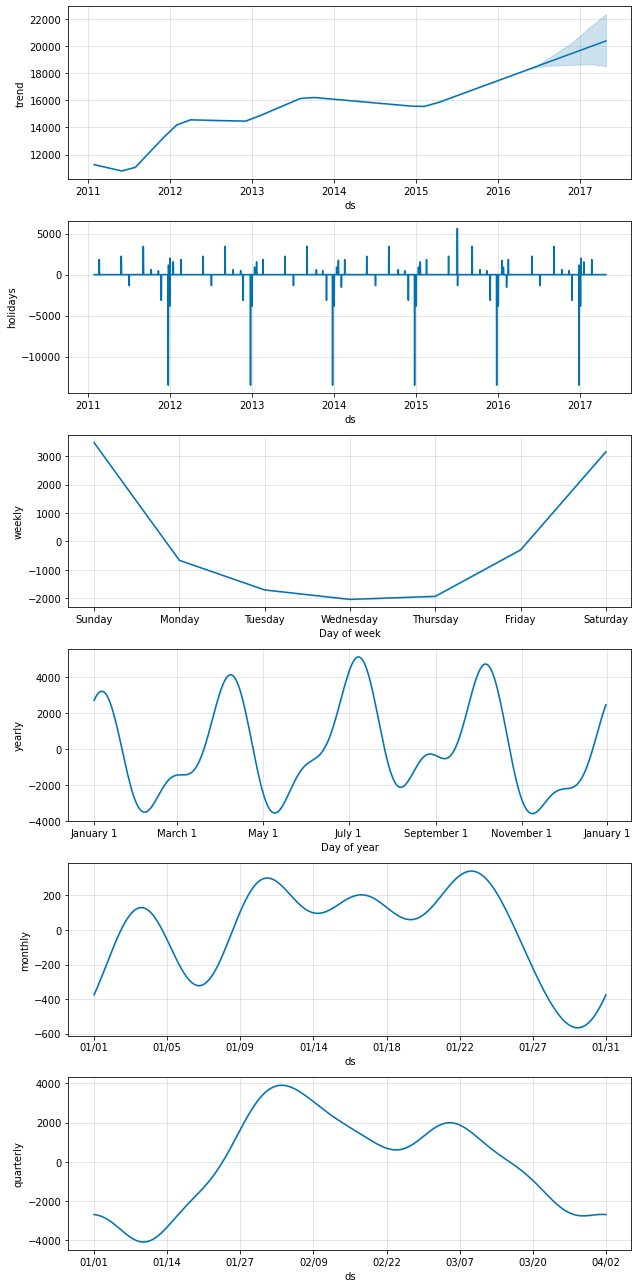

In [53]:
fig = m2.plot_components(forecast2)

In [54]:
plot_plotly(m2, forecast2)

In [62]:
forecast2.yhat

0       13558.645845
1       14309.838677
2       10407.299237
3        9434.072816
4        9114.604079
            ...     
2273    18305.766011
2274    19803.043484
2275    23199.617567
2276    23568.310294
2277    19533.142120
Name: yhat, Length: 2278, dtype: float64

In [64]:
from sklearn.metrics import (explained_variance_score, 
                            mean_absolute_error, 
                            mean_squared_error,
                            mean_absolute_percentage_error,
                            median_absolute_error,
                            r2_score)

In [90]:
print('Model 1')
print('Explained variance: {: .2f}'.format(explained_variance_score(df_for_prophet.y, forecast.yhat[:1913])))
print('MAE: {: .2f}'.format(mean_absolute_error(df_for_prophet.y, forecast.yhat[:1913])))
print('mean_squared_error: {: .2f}'.format(mean_squared_error(df_for_prophet.y, forecast.yhat[:1913])))
print('mean_absolute_percentage_error: {: .2f}'.format(mean_absolute_percentage_error(df_for_prophet.y, forecast.yhat[:1913])))
print('median_absolute_error: {: .2f}'.format(median_absolute_error(df_for_prophet.y, forecast.yhat[:1913])))

Model 1
Explained variance: -0.84
MAE:  3549.83
mean_squared_error:  19500004.43
mean_absolute_percentage_error:  6.97
median_absolute_error:  3021.69


In [91]:
print('Model 2')
print('Explained variance: {: .2f}'.format(explained_variance_score(df_for_prophet.y, forecast2.yhat[:1913])))
print('MAE: {: .2f}'.format(mean_absolute_error(df_for_prophet.y, forecast2.yhat[:1913])))
print('mean_squared_error: {: .2f}'.format(mean_squared_error(df_for_prophet.y, forecast2.yhat[:1913])))
print('mean_absolute_percentage_error: {: .2f}'.format(mean_absolute_percentage_error(df_for_prophet.y, forecast2.yhat[:1913])))
print('median_absolute_error: {: .2f}'.format(median_absolute_error(df_for_prophet.y, forecast2.yhat[:1913])))

Model 2
Explained variance: -0.94
MAE:  3612.09
mean_squared_error:  20544860.46
mean_absolute_percentage_error:  7.09
median_absolute_error:  3088.96


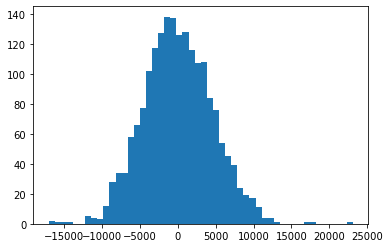

In [96]:
plt.hist([df_for_prophet.y - forecast2.yhat[:1913]], bins=50)
plt.show()

In [104]:
error_list = [df_for_prophet.y - forecast2.yhat[:1913]]
mean_error = np.mean(error_list)
error_mean_error = np.std(error_list, ddof=1) / np.sqrt(np.size(error_list))
print(mean_error, error_mean_error, mean_error - 1.96*error_mean_error, mean_error + 1.96*error_mean_error)

0.047943697146797755 103.65915253822308 -203.12399527777043 203.21988267206402


In [136]:
from datetime import timedelta
df_for_prophet.ds.max() - timedelta(days=730)    # на последних 730 днях кроссвалидирую
df_for_prophet[df_for_prophet.ds < '2014-04-25 00:00:00'].count()  # или начиная с 1182 наблюдения

y     1182
ds    1182
dtype: int64

In [138]:
df_cv = cross_validation(m2, 
                        initial='1182 days',       # отсюда начинается кросс-валидация
                        period='180 days',        # таким окном
                        horizon = '365 days')     # на таком периоде от initial

INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-04-30 00:00:00 and 2015-04-25 00:00:00
100%|██████████| 3/3 [00:29<00:00,  9.71s/it]


In [139]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse         rmse         mae      mape     mdape  coverage
0 37 days  1.353330e+06  1163.327044  891.876885  0.056177  0.045119  0.730887
1 38 days  1.400174e+06  1183.289507  909.247238  0.057162  0.046895  0.721713
2 39 days  1.381002e+06  1175.160233  899.096398  0.056550  0.046895  0.724771
3 40 days  1.357673e+06  1165.192127  888.507071  0.055664  0.045163  0.730887
4 41 days  1.338347e+06  1156.869655  883.207926  0.055348  0.045119  0.740061

In [148]:
fig = plot_cross_validation_metric(df_cv, metric='coverage')

In [162]:
import itertools
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
cutoffs = pd.to_datetime(['2014-04-30', '2014-10-30', '2015-04-30'])

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_for_prophet)  # Fit model with given params
    # m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
    # m.add_seasonality('monthly', period=30.5, fourier_order=5)
    # m.add_country_holidays(country_name='US')
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

TypeError: __init__() got an unexpected keyword argument 'holidays_prior_scale '

In [168]:
def getPerfomanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')

def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(holidays=holidays, **param_dict)
    m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
    m.add_seasonality('monthly', period=30.5, fourier_order=5)
    m.add_country_holidays(country_name='US')
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p


#'changepoint_range': [0.6, 0.7, 0.75, 0.8, 0.9],
#'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.25, 0.5],
#'seasonality_prior_scale':[0.5, 1.0, 2.5, 5],
#'holidays_prior_scale':[1.0, 5.0, 10.0, 15.0],
#'yearly_seasonality':[5, 10, 15, 20],
#'weekly_seasonality':[5, 10, 15, 20],
pd.set_option('display.max_colwidth', None)
param_grid = {                  
                'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.25, 0.5],
                # 'changepoint_range': [0.3],
                'holidays_prior_scale':[1.0, 5.0, 10.0, 15.0],
                'seasonality_prior_scale':[0.01, 0.1, 1.0, 10.0],
                'yearly_seasonality':[20],
                'weekly_seasonality':[5],
              }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape', 'coverage','params'] 
results = []

#Prophet(,)
params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df_for_prophet,  metrics, param_dict, parallel="processes")
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df.mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 27 forecasts with cutoffs between 2013-02-08 00:00:00 and 2015-04-25 00:00:00
100%|██████████| 27/27 [03:10<00:00,  7.05s/it]
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 27 forecasts with cutoffs between 2013-02-08 00:00:00 and 2015-04-25 00:00:00
100%|██████████| 27/27 [03:09<00:00,  7.01s/it]
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 27 forecasts with cutoffs between 2013-02-08 00:00:00 and 2015-04-25 00:00:00
100%|██████████| 27/27 [03:49<00:00,  8.51s/it]
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 27 forecasts with cutoffs between 2013-02-08 00:00:00 and 2015-04-25 00:00:00
100%|██████████| 27/27 [03:07<00:00,  6.95s/it]


KeyboardInterrupt: 

'performance_metrics'